In [1]:
#$HIDE$
# Setup. Import libraries and load dataframes for Movielens data.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random

input_dir = '../input/movielens_preprocessed'
ratings_path = os.path.join(input_dir, 'rating.csv')

ratings_df = pd.read_csv(ratings_path, usecols=['userId', 'movieId', 'rating'])

movies_df = pd.read_csv(os.path.join(input_dir, 'movie.csv'), usecols=['movieId', 'title', 'year'])

df = ratings_df.merge(movies_df, on='movieId').sort_values(by='userId')
df = df.sample(frac=1, random_state=1) # Shuffle

In this lesson, I'll show how we can use embedding layers to build a neural net that handles **sparse categorical inputs**. What does that mean? As an example, I'll be working on the problem of predicting user-ratings of movies with the [MovieLens dataset](https://www.kaggle.com/grouplens/movielens-20m-dataset/home). Here's a taste of the data:

In [2]:
df.sample(10, random_state=1)

,userId,movieId,rating,title,year
9264799,85731,7939,4.0,Fahrenheit 9/11,2004
12922675,45008,5321,3.0,The Bourne Identity,2002
3006176,125144,2865,4.0,"Fistful of Dollars, A (Per un pugno di dollari)",1964
4034821,122230,1661,2.0,Titanic,1997
13682758,21156,14579,3.0,Sherlock Holmes,2009
19946858,101732,16203,3.5,M,1951
14636235,17273,2061,5.0,Pretty in Pink,1986
13901939,102385,1197,4.0,A Grand Day Out with Wallace and Gromit,1989
19120292,72480,4331,2.0,Kiss Me Deadly,1955
13051554,102299,4883,3.5,The Royal Tenenbaums,2001


Ratings range from 0.5 stars to 5. Our goal will be to predict what rating a given user $u$ would have given a particular movie $m$. 

What do I mean when I say that `userId` and `movieId` are sparse? Just that there are a lot of possible values:

**TODO: I wonder if people will object to my use of terminology here. Maybe a more accurate (but more wordy/technical) characterization would be "high-cardinality categorical data"?**

In [3]:
n_movies = len(df.movieId.unique())
n_users = len(df.userId.unique())
print(
    "{:,} distinct users rated {:,} different movies (total ratings = {:,})".format(
        n_movies, n_users, len(df),
    )
)

26,744 distinct users rated 138,493 different movies (total ratings = 20,000,263)


If we treated each user and movie as a separate boolean variable, then each instance would have ~165k numbers, of which exactly 2 would be non-zero. Sparse indeed!

# Baselines

It's always useful to start with a simple baseline model. This will give us a useful reference to compare to later on.

Perhaps the simplest baseline of all is to always predict the same number: the average over all ratings in the training set.

In [4]:
#$HIDE_INPUT$
from sklearn.model_selection import train_test_split
from sklearn import metrics

df_train, df_val = train_test_split(df, test_size=.05, random_state=1)

def get_metrics(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred), metrics.mean_squared_error(y_true, y_pred)

mean_rating = df_train['rating'].mean()
print("Average rating in training set is {:.2f} stars".format(mean_rating))

y_true = df_val['rating'].values
always_mean = np.full(y_true.shape, mean_rating)

mae, mse = get_metrics(y_true, always_mean)
print("Always predicting global mean results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(
    mae, mse))

Average rating in training set is 3.53 stars
Always predicting global mean results in Mean Absolute Error=0.84, Mean Squared Error=1.11


This dumb baseline is, on average, off by about .84 stars. If we can't do better than that, then something has gone very wrong.

Of course we would expect that, setting aside the issue of individual taste, some movies are intrinsically better or worse than others.

In [5]:
#$HIDE_INPUT$
from IPython.display import display
movies = movies_df.copy().set_index('movieId')
mean_per_movie = df_train.groupby('movieId')['rating'].mean()
movies['mean_rating'] = mean_per_movie
ratings_per_movie = df_train.groupby('movieId').size()
movies['n_ratings'] = ratings_per_movie

flops = movies[movies['n_ratings'] > 10].sort_values(by='mean_rating').head()

smashes = movies[movies['n_ratings'] > 10].sort_values(by='mean_rating', ascending=False).head()
print("Movies with lowest average rating:")
display(flops)
print()
print("Movies with highest average rating:")
display(smashes)

Movies with lowest average rating:


,title,year,mean_rating,n_ratings
movieId,,,,
7170,"Hip Hop Witch, Da",2000,0.732143,28.0
8176,SuperBabies: Baby Geniuses 2,2004,0.839196,199.0
6373,From Justin to Kelly,2003,0.961443,402.0
12003,Bratz: The Movie,2007,1.055882,170.0
4679,Glitter,2001,1.120717,642.0



Movies with highest average rating:


,title,year,mean_rating,n_ratings
movieId,,,,
20747,Death on the Staircase (Soupçons),2004,4.475000,20.0
315,The Shawshank Redemption,1994,4.446200,60214.0
843,The Godfather,1972,4.364902,39290.0
49,The Usual Suspects,1995,4.334947,44631.0
523,Schindler's List,1993,4.310460,47581.0


A simple improvement to take advantage of this would be to predict, given user $u_i$ and movie $m_j$, the average of all ratings given to $m_j$ by other users. 

In [6]:
#$HIDE_INPUT$
# There are a few movies in the validation set not present in the training set. We'll just use the global
# mean rating in their case.
y_movie_mean = df_val.join(mean_per_movie, on='movieId', rsuffix='mean')['ratingmean'].fillna(mean_rating).values

mae, mse = get_metrics(y_true, y_movie_mean)
print("Predicting mean per movie results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(mae, mse))

Predicting mean per movie results in Mean Absolute Error=0.73, Mean Squared Error=0.89


A pretty substantial improvement. What about predicting the average of the ratings given by the user?

In [7]:
#$HIDE_INPUT$
mean_per_user = df_train.groupby('userId')['rating'].mean()
y_user_mean = df_val.join(mean_per_user, on='userId', rsuffix='mean')['ratingmean'].fillna(mean_rating).values
mae, mse = get_metrics(y_true, y_user_mean)
print("Predicting mean per user results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(mae, mse))

Predicting mean per user results in Mean Absolute Error=0.75, Mean Squared Error=0.93


Still better than predicting the global average, but the choice of user seems less informative than the movie.

From here, we could look at combining these estimates using some kind of weighted average - but now we're moving past the realm of a simple baseline. So let's just throw some machine learning at it!

# Building a rating prediction model in Keras

We want to build a model that takes a user, $u_i$ and a movie, $m_j$, and outputs a number from 0.5-5, representing how many stars we think this user would give that movie. (You may have noticed that the [MovieLens dataset](https://www.kaggle.com/grouplens/movielens-20m-dataset) includes information about each movie such as its title, its year of release, a set of genres and user-assigned tags. But for now, we're not going to try to exploit any of that extra information.)

How should we handle these sparse categorical inputs? Let's start by mentioning a couple reasonable-sounding approaches that won't work here.

## Bad idea #1: Use user ids and movie ids as numerical inputs

Why not feed in user ids and movie ids as inputs, then add on some dense layers and call it a day?

In the simplest terms, neural nets work by doing math on their inputs. But the actual numerical values of the ids assigned to users and movies are meaningless. *Schindler's List* has id 527 and *The Usual Suspects* has id 50, but that doesn't mean *Schindler's List* is 'ten times bigger' than *The Usual Suspects*.

## Bad idea #2: One-hot encoded user and movie inputs

If you're not familiar with one-hot encoding, you may want to check out our lesson [Using Categorical Data with One Hot Encoding](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding).

In that lesson, we claim that one-hot encoding is "The Standard Approach for Categorical Data". So why is it a bad idea here? Let's see what a model would look like that took one-hot encoded users and movies.

In [8]:
input_size = n_movies + n_users
print("Input size = {:,} ({:,} movies + {:,} users)".format(
    input_size, n_movies, n_users,
))
model = keras.Sequential([
    # One hidden layer with 128 units
    keras.layers.Dense(128, input_dim=input_size, activation='relu'),
    # A single output node, containing the predicted rating
    keras.layers.Dense(1)
])
model.summary()

Input size = 165,237 (26,744 movies + 138,493 users)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               21150464  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 21,150,593
Trainable params: 21,150,593
Non-trainable params: 0
_________________________________________________________________


A basic issue here is scaling and efficiency. A single input to our model is a vector of 165,237 numbers (of which we know that 165,235 will be zeros). The feature data for our whole dataset of 20 million rating instances will require a 2-d array of shape (20,000,000, 165,237), or about 3 **trillion** numbers. Good luck fitting that all into memory at once!

Also, doing training and inference on our model will be inefficient. To calculate the activations of our first hidden layer, we'll need to multiply our 165k inputs through about 21 million weights - but the vast, vast majority of those products will just be zero.

**TODO: diagram showing this**

One-hot encoding is fine for categorical variables with a small number of possible values, like `{Red, Yellow, Green}`, or `{Monday, Tuesday, Wednesday, Friday, Saturday, Sunday}`. But it's not so great in cases like our movie recommendation problem, where variables have tens or hundreds of thousands of possible values.

## Good idea: Embedding layers

In short, an **embedding layer** maps each element in a set of discrete things (like words, users, or movies) to a dense vector of real numbers (its **embedding**). 

A key implementation detail is that embedding layers take as input the *index* of the entity being embedded (i.e. we can give it our userIds and movieIds as input). You can think of it as a sort of 'lookup table'. This is much more efficient than taking a one-hot vector and doing a huge matrix multiplication!

As an example, if we learn embeddings of size 8 for movies, the embedding for *Legally Blonde* (index=4352) might look like:

$$[ 1.624, -0.612, -0.528, -1.073,  0.865, -2.302,  1.745, -0.761]$$

**Where do these come from?** We initialize an embedding for each user and movie using random noise, then we train them as part of the process of training the overall rating-prediction model. 

**What do they mean?** An object's embedding, if it's any good, should capture some useful latent properties of that object. But the key word here is *latent* AKA hidden. It's up to the model to discover whatever properties of the entities are useful for the prediction task, and encode them in the embedding space. Sound mysterious? In later lessons I'll show some techniques for interpreting learned embeddings, such as visualizing them with T-SNE.

## Implementing it

I want my model to look something like this:

**TODO: diagram**

A key thing to note is that this network is not simply a stack of layers from input to output. We're treating the user and the movie as separate inputs, which come together only after each has gone through its own embedding layer.

This means that the [keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) class that we've been using up to this point won't work. We'll need to turn to the more powerful 'functional API', using the [keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class.

Here's the code:

In [9]:
hidden_units = (32,4)
movie_embedding_size = 8
user_embedding_size = 8

# Each instance will consist of two inputs: a single user id, and a single movie id
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
# Concatenate the embeddings (and remove the useless extra dimension)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         1107952     user_id[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 8)         213952      movie_id[0][0]                   
__________________________________________________________________________________________________
concatenat

### `keras.Model` vs. `keras.Sequential `

**TODO: not sure this section is necessary. It's really only useful to readers who are familiar with Sequential but not familiar with Model. I'm not convinced that they'll be a majority. Maybe just link to the Functional API guide. It would be nice to have some consistent design elements we could use for various kinds of optional content. e.g. technical notes on the code, or more theoretical asides**

If you're used to using `keras.Sequential`, one difference you might notice here is that, after creating each layer, we *call* it, explicitly passing in the inputs to that layer. For example:

```python
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
```

If we wanted, we could explicitly break this into two steps. The following code is equivalent:

```python
concatenate_layer = keras.layers.Concatenate()
concatenated = concatenate_layer([user_embedded, movie_embedded])
```

Another difference is that we must explicitly create [keras.Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) objects for each input to our model (and pass them to `keras.Model`'s constructor).

For more detail on the Functional API, check out [Keras's guide, here](https://keras.io/getting-started/functional-api-guide/).

## Training it

We'll compile our model to minimize squared error ('MSE'). We'll also include absolute error ('MAE') as a metric to report during training, since it's a bit easier to interpret.

> Something to think about: We know that ratings can only take on the values `{0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5}` - so why not treat this as a multiclass classification problem with 10 classes, one for each possible star rating?

In [10]:
tf.set_random_seed(1); np.random.seed(1); random.seed(1)
model.compile(
    # Technical note: when using embedding layers, I highly recommend using one of the optimizers
    # found  in tf.train: https://www.tensorflow.org/api_guides/python/train#Optimizers
    # Passing in a string like 'adam' or 'SGD' will load one of keras's optimizers (found under 
    # tf.keras.optimizers). They seem to be much slower on problems like this, because they
    # don't efficiently handle sparse gradient updates.
    tf.train.AdamOptimizer(0.005),
    loss='MSE',
    metrics=['MAE'],
)

Let's train the model.

In [11]:
#$HIDE_OUTPUT$
history = model.fit(
    [df.userId, df.movieId],
    df.rating,
    batch_size=5000,
    epochs=20,
    verbose=2,
    validation_split=.05,
);

Train on 19000249 samples, validate on 1000014 samples
Epoch 1/20
 - 53s - loss: 0.7757 - mean_absolute_error: 0.6754 - val_loss: 0.7129 - val_mean_absolute_error: 0.6483
Epoch 2/20
 - 57s - loss: 0.6945 - mean_absolute_error: 0.6385 - val_loss: 0.6882 - val_mean_absolute_error: 0.6323
Epoch 3/20
 - 55s - loss: 0.6702 - mean_absolute_error: 0.6264 - val_loss: 0.6764 - val_mean_absolute_error: 0.6262
Epoch 4/20
 - 55s - loss: 0.6550 - mean_absolute_error: 0.6187 - val_loss: 0.6795 - val_mean_absolute_error: 0.6394
Epoch 5/20
 - 55s - loss: 0.6414 - mean_absolute_error: 0.6119 - val_loss: 0.6630 - val_mean_absolute_error: 0.6194
Epoch 6/20
 - 57s - loss: 0.6297 - mean_absolute_error: 0.6060 - val_loss: 0.6590 - val_mean_absolute_error: 0.6236
Epoch 7/20
 - 51s - loss: 0.6203 - mean_absolute_error: 0.6013 - val_loss: 0.6655 - val_mean_absolute_error: 0.6163
Epoch 8/20
 - 58s - loss: 0.6134 - mean_absolute_error: 0.5978 - val_loss: 0.6533 - val_mean_absolute_error: 0.6195
Epoch 9/20
 - 69s

Here's a plot of our absolute error over time. As a reminder, our best baseline predictor had an average error of .73 (shown as a dotted line below).

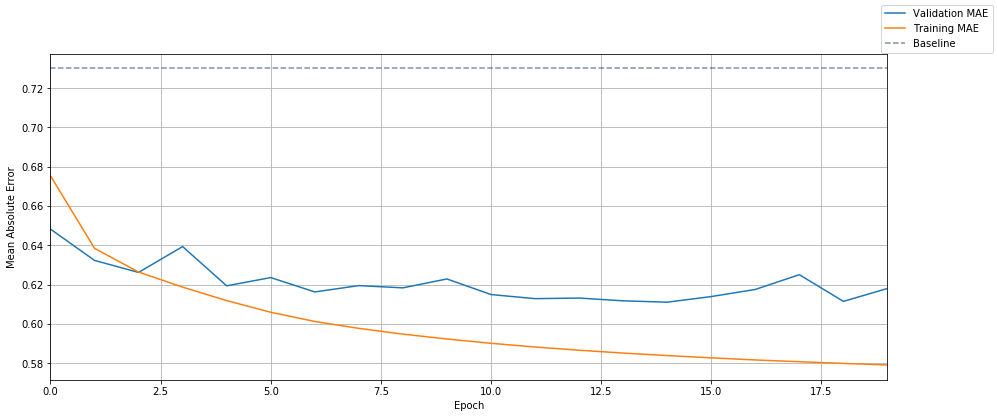

In [12]:
#$HIDE_INPUT$
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(history.epoch, history.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

In [18]:
#$HIDE$
# Save training history for later comparison
hdf = pd.DataFrame(dict(
    epoch=history.epoch,
    val_mae=history.history['val_mean_absolute_error'],
    train_mae=history.history['mean_absolute_error'],
))
hdf.to_csv('history-1.csv')

Compared to the baseline, we were able to get our average error down by more than .1 stars. Not bad!

## Example predictions

Let's try some example predictions as a sanity check. We'll start by picking out a specific user from the dataset at random.

In [14]:
ratings_per_user = df.groupby('userId').size()
uid = ratings_per_user[ratings_per_user < 30].sample(1, random_state=1).index[0]
user_ratings = df[df.userId==uid]
print("User #{} has rated {} movies (avg. rating = {:.1f})".format(
    uid, len(user_ratings), user_ratings['rating'].mean(),
))
user_ratings.sort_values(by='rating', ascending=False)

User #26556 has rated 21 movies (avg. rating = 3.7)


,userId,movieId,rating,title,year
2932780,26556,2705,5.0,Airplane!,1980
15253028,26556,2706,5.0,Airplane II: The Sequel,1982
4304453,26556,2286,4.5,Fletch,1985
4590121,26556,2863,4.5,Dr. No,1962
14534899,26556,2216,4.5,History of the World: Part I,1981
14465815,26556,2102,4.5,Strangers on a Train,1951
14297289,26556,534,4.5,Six Degrees of Separation,1993
10069393,26556,937,4.5,Mr. Smith Goes to Washington,1939
16276146,26556,916,4.0,To Catch a Thief,1955
16093723,26556,913,4.0,Notorious,1946


User 26556 has given out two perfect ratings to the movies *Airplane!* and *Airplane II: The Sequel*. Great choices! Perhaps they'd also enjoy the [*The Naked Gun*](https://en.wikipedia.org/wiki/The_Naked_Gun) series - another series of spoof films starring Leslie Nielsen.

**TODO: There's gotta be a way to fit in a "What's our vector, Victor?" quote somewhere in this course...**

We don't have as much evidence about what this user hates. They gave a low rating to *The Day the Earth Stood Still*, but it's hard to extrapolate much from that one data point. Do they not like science fiction? Do they not like *retro* science fiction? Let's try predicting their rating on some sci-fi flicks to see what the model has to say.

A better indication of this user's dislikes might be the kinds of movies they haven't even rated. Let's also throw in a couple examples of movies that this user seems unlikely to ever watch, according to their rating history.

In [15]:
candidate_movies = movies[
    movies.title.str.contains('Naked Gun')
    | ((movies.title == 'Planet of the Apes') & (movies.year==1968))
    | ((movies.title == 'The Blob') & (movies.year==1958))
    | (movies.title == 'The Sisterhood of the Traveling Pants')
    | (movies.title == 'Lilo & Stitch')
].copy()

preds = model.predict([
    [uid] * len(candidate_movies), # User ids 
    candidate_movies.index, # Movie ids
])
candidate_movies['predicted_rating'] = preds
# Add a column with the difference between our predicted rating (for this user) and the movie's
# overall average rating across all users in the dataset.
candidate_movies['delta'] = candidate_movies['predicted_rating'] - candidate_movies['mean_rating']
candidate_movies.sort_values(by='delta', ascending=False)

,title,year,mean_rating,n_ratings,predicted_rating,delta
movieId,,,,,,
3776,The Naked Gun 2 1/2: The Smell of Fear,1991,3.133348,4432.0,4.729352,1.596004
3775,The Naked Gun: From the Files of Police Squad!,1988,3.576741,6978.0,5.070251,1.493509
366,Naked Gun 33 1/3: The Final Insult,1994,2.952640,13524.0,4.140424,1.187784
1305,The Blob,1958,3.107279,2624.0,4.066791,0.959512
2444,Planet of the Apes,1968,3.619545,12075.0,4.116387,0.496843
5347,Lilo & Stitch,2002,3.491425,4373.0,3.115351,-0.376074
10138,The Sisterhood of the Traveling Pants,2005,3.379064,769.0,2.818669,-0.560395


Looks pretty reasonable! For each of the movies in the *The Naked Gun* series, our predicted ratings for this user are a full star above the average rating in the dataset. Somewhat surprisingly, our old sci-fi movies have a somewhat higher predicted rating than average. But it's good to see that our 'out of left field' picks have their predicted ratings downgraded compared to average.

# Your turn

**TODO: Exercises link goes here**

In [2]:
# scratch space below